In [356]:


from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# parse commandline arguments
op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()


Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



In [307]:
from fastai.text import *

In [308]:
PATH=Path('data/enron/')
labeled=pd.read_excel(PATH/"labeled.xlsx",header=None,names=["label","text"])
labeled=labeled.sample(frac=1)


In [325]:


labeled=labeled[labeled['label']!=3]
all_class_test=True
if all_class_test:
    labeled=labeled[labeled['label']!=0]
labeled=labeled.sample(frac=1)


In [326]:
if False:
    clas1=0.0
    clas2=2.0
    drop_clas=1.0
    clas_rep=2.0
    labeled[labeled["label"]==drop_clas]=clas_rep
    print(len(labeled[labeled['label']==clas1].values))
    print(len(labeled[labeled['label']==clas2].values))
    n=min([len(labeled[labeled['label']==clas1].values),len(labeled[labeled['label']==clas2].values)])
    df1=labeled[labeled['label']==clas2].sample(n)
    df2=labeled[labeled['label']==clas1].sample(n)
    labeled = pd.concat([df1,df2]).sample(frac=1)
    

In [327]:
labeled.describe()

,label
count,635.000000
mean,1.475591
std,0.499798
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [328]:
part=int(len(labeled)*0.8)

data_train=labeled[:part]
data_test=labeled[part:]
X_train, y_train=data_train.text,data_train.label
X_test, y_test=data_test.text,data_test.label


In [329]:
print(y_train.count(),y_test.count())

508 127


In [330]:
labeled.describe()

,label
count,635.000000
mean,1.475591
std,0.499798
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [331]:
use_hash=False

print("Extracting features from the training data using a sparse vectorizer")
t0 = time.time()
if use_hash:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.text.values.astype('U'))
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.text.values.astype('U'))
duration = time.time() - t0
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

Extracting features from the training data using a sparse vectorizer
n_samples: 508, n_features: 10592



In [332]:




print("Extracting features from the test data using the same vectorizer")
t0 = time.time()
X_test = vectorizer.transform(data_test.text.values.astype('U'))
duration = time.time() - t0
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

Extracting features from the test data using the same vectorizer
n_samples: 127, n_features: 10592



In [333]:
# mapping from integer feature name to original token string
if use_hash:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.016s
test time:  0.000s
accuracy:   0.535
dimensionality: 10592
density: 1.000000

classification report:
             precision    recall  f1-score   support

       news       0.60      0.51      0.55        71
        FIY       0.48      0.57      0.52        56

avg / total       0.55      0.54      0.54       127

confusion matrix:
[[36 35]
 [24 32]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=None, n_iter=50, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)
train time: 0.005s
test time:  0.000s
a

/Users/alexanderleirvag/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
/Users/alexanderleirvag/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 3
  .format(len(labels), len(target_names))
/Users/alexanderleirvag/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/alexanderleirvag/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 3
  .format(le

train time: 0.352s
test time:  0.012s
accuracy:   0.583
classification report:
             precision    recall  f1-score   support

       news       0.62      0.68      0.64        71
        FIY       0.53      0.46      0.50        56

avg / total       0.58      0.58      0.58       127

confusion matrix:
[[48 23]
 [30 26]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.006s
test time:  0.000s
accuracy:   0.535
dimensionality: 10592
density: 1.000000

classification report:
             precision    recall  f1-score   support

       news       0.60      0.51      0.55        71
        FIY       0.48      0.57      0.52        56

avg / total       0.55      0.54      0.54       127

confusion matri

/Users/alexanderleirvag/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 3
  .format(len(labels), len(target_names))
/Users/alexanderleirvag/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 3
  .format(len(labels), len(target_names))
/Users/alexanderleirvag/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/alexanderleirvag/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 3
  .format(len(labels), len(target_names))
/Users/alexanderleirvag/anaconda/envs/python3/lib/python3.6/site-

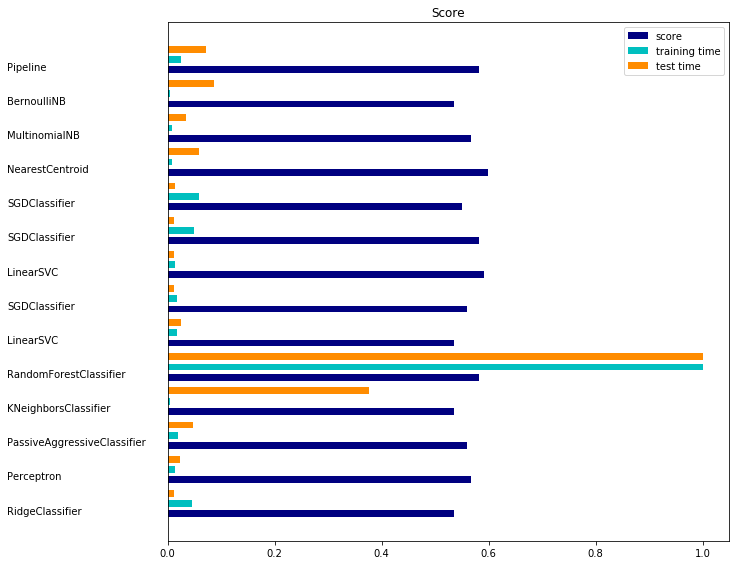

In [334]:
from sklearn.metrics import confusion_matrix

target_names=["news","FIY","MUST"]


# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time.time()
    pred = clf.predict(X_test)
    
    #print(confusion_matrix(y_test, pred))
    test_time = time.time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if True:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if True:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [335]:
sample1="""Dear Ms. Jones,

I am writing to you to request that you provide a reference for me as I begin my job search. As you know, I will be completing my graduate studies this spring, and have found several exciting opportunities that I am exploring.

As my undergraduate thesis advisor and mentor, I believe that a reference from you would provide a potential employer with information to recommend me as a school counselor.

If you need any additional information, please contact me via email or phone.

Thank you for your consideration and support.

Sincerely,

Jessica Angel
555-123-4567
jessicaa@aaa.com
"""


In [351]:
sample2="""
Hi,

I just went a head and booked the meeting.

Best A
"""

In [352]:
clf=RidgeClassifier(tol=1e-2, solver="lsqr")
if use_hash:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.text.values.astype('U'))
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.text.values.astype('U'))
sample_transformed_1 = vectorizer.transform([sample1])
sample_transformed_2 = vectorizer.transform([sample2])


In [353]:
clf.fit(X_train,y_train)

/Users/alexanderleirvag/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:319: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)

In [354]:
clf.predict(sample_transformed_1)

array([2])

In [355]:
clf.predict(sample_transformed_2)

array([2])